# Spatial Correlation Matrix to AOA

This repo aims to learn the AOA of LoRa beacons from Spatial Correlation Matrix, R. Here is the nice article how support vector method (e.g, SVR) can also be used for regression.

https://www.saedsayad.com/support_vector_machine_reg.htm

In [1]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
%matplotlib inline

## Preparation
Create dataset for training and testing from Rosbag recorded .csv file named as 'deg_(theta).csv'. Useful features lie in field 1, 2, 3, 6, 7, and 11 of the spatial correlation matrix, R.

In [2]:
data_dir = 'data_0106'
aoa_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [3]:
aoa_dict[-60].head()

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11
0,1.991174e-08,1.028969e-08,6.949319e-08,-2.010913e-07,6.824267e-08,0.000002
1,1.831539e-08,1.150122e-08,7.293450e-08,-1.223310e-07,1.623128e-07,0.000002
2,1.820912e-08,1.208390e-08,6.593048e-08,-1.448767e-07,1.018442e-07,0.000002
3,2.016857e-08,1.256068e-08,7.107637e-08,-1.344811e-07,9.275814e-08,0.000002
4,2.285401e-08,1.230451e-08,7.479932e-08,-1.361074e-07,1.538713e-07,0.000002


In [4]:
aoa_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field.data1   269 non-null    float64
 1   field.data2   269 non-null    float64
 2   field.data3   269 non-null    float64
 3   field.data6   269 non-null    float64
 4   field.data7   269 non-null    float64
 5   field.data11  269 non-null    float64
dtypes: float64(6)
memory usage: 12.7 KB


In [5]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Show detection of LoRa beacon when Rjk is significant
aoa_dict[0][abs(aoa_dict[0]['field.data1']) > 1e-04]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
0,0.000399,-0.000359,-0.000245,-0.000937,0.001014,0.011725,0.0
14,0.006042,-0.004273,-0.002901,-0.016413,0.004441,0.104454,0.0
15,0.005552,-0.004102,-0.002887,-0.015961,0.002742,0.102230,0.0
16,0.005755,-0.004104,-0.003070,-0.017788,-0.001712,0.101776,0.0
17,0.004123,-0.004381,-0.004346,-0.014538,-0.000627,0.121335,0.0
...,...,...,...,...,...,...,...
258,0.005880,-0.001043,0.000075,-0.000127,0.009145,0.014606,0.0
259,0.006537,-0.001173,0.000117,0.000152,0.010935,0.016574,0.0
260,0.006470,-0.001204,0.000089,-0.000045,0.011023,0.017472,0.0
261,0.006530,-0.001210,0.000076,-0.000214,0.011017,0.018170,0.0


In [7]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) < 1e-04].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) >= 1e-04].index)

In [8]:
aoa_sig[60]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
5,0.026438,-0.014055,-0.034578,-0.084833,-0.366615,0.195672,1.047198
6,0.026774,-0.013786,-0.034818,-0.082009,-0.367695,0.192285,1.047198
7,0.026639,-0.013434,-0.034519,-0.075749,-0.371168,0.185148,1.047198
8,0.026184,-0.014034,-0.034509,-0.088851,-0.379352,0.189543,1.047198
9,0.026539,-0.014476,-0.034825,-0.088819,-0.377695,0.197761,1.047198
...,...,...,...,...,...,...,...
407,0.000307,-0.002767,-0.003226,0.014748,-0.013180,0.039275,1.047198
408,0.000625,-0.002981,-0.003772,0.013551,-0.019973,0.039902,1.047198
409,0.000861,-0.003104,-0.004055,0.013314,-0.022932,0.040916,1.047198
410,0.001166,-0.003441,-0.004696,0.011603,-0.028606,0.043699,1.047198


In [9]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[-60], aoa_sig[-50], aoa_sig[-40], aoa_sig[-30], aoa_sig[-20], aoa_sig[-10], aoa_sig[0], aoa_sig[10], aoa_sig[20], aoa_sig[30], aoa_sig[40], aoa_sig[50], aoa_sig[60]], ignore_index=True)
Xaoa['theta'].value_counts()

 0.872665    145
-0.349066    138
 1.047198    125
 0.698132    114
 0.349066    101
 0.174533     95
-1.047198     92
-0.174533     89
 0.000000     78
-0.872665     71
-0.698132     70
 0.523599     58
-0.523599     55
Name: theta, dtype: int64

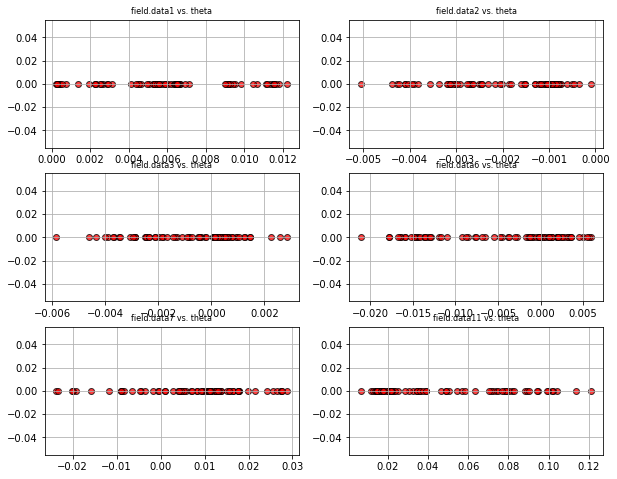

In [10]:
# Visualize data
fig,ax = plt.subplots(3,2,figsize=(10,8))
ax = ax.ravel()
visual_key = 0
for i in range(6):
    ax[i].scatter(aoa_sig[visual_key][aoa_sig[visual_key].columns[i]],aoa_sig[visual_key]['theta'],edgecolor='k',color='red',alpha=0.75)
    ax[i].set_title(f"{aoa_sig[visual_key].columns[i]} vs. theta",fontsize=8)
    ax[i].grid(True)
plt.show()

## Training
### SVR
Here is scikit-learn's SVR doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [11]:
X = Xaoa.drop('theta', axis=1)
y = Xaoa['theta']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
'''
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
'''

'\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.fit_transform(X_test)\n'

### Kernal arg: 'rbf' vs 'sigmoid' vs 'linear'

In [14]:
# Support vector regressor with Gaussian (Radial Basis Function) kernel
svr_1 = SVR(kernel='rbf',gamma='scale', C=2.0, epsilon=0.3)
svr_1.fit(X_train, y_train) 

SVR(C=2.0, epsilon=0.3)

In [15]:
svr_1.score(X_test,y_test)

0.6518584896816233

In [16]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_1.predict(X_test))))

RMSE for RBF kernelized SVR: 0.3852566354423806


In [17]:
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_1,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=SVR(C=2.0, epsilon=0.3),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5],
                         'epsilon': [0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='r2', verbose=1)

In [18]:
grid.best_estimator_

SVR(C=5)

In [19]:
svr_best=SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.3)
svr_best.fit(X_train, y_train)
svr_best.score(X_test, y_test)

0.6752965450870837

In [20]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_best.predict(X_test))))

RMSE for RBF kernelized SVR: 0.3720623097177503


In [21]:
low_bound = 150
high_bound = 200
pred_y = svr_best.predict(X_test[low_bound:high_bound])
print(pred_y)

[ 0.75738927 -0.59503799  0.28668487  0.41931718  0.1850472   1.1946854
  0.31556508  0.11971728  0.61187773 -1.26512792 -0.62379803  0.55730759
  0.95881409 -0.01770198  0.59672676  0.13778572  0.14149431  0.26747001
  0.26169637  0.2328935  -0.89847703 -0.70399804  0.19548203  0.4561583
  0.42541049  0.3930561  -0.61438316 -0.85609786 -0.98755323  0.12861823
  0.22192352 -0.41779257 -0.89800314 -0.56934451 -0.71096435  0.24147868
 -0.70282857  0.87889231 -0.28738258  0.17034688  0.53492913  0.18755434
  0.51664441  0.19672257 -0.45875119 -0.38609994  0.37397472 -0.62230089
 -0.75399445  0.36298371]


In [22]:
y_test[low_bound:high_bound]
print(y_test.shape)

(247,)


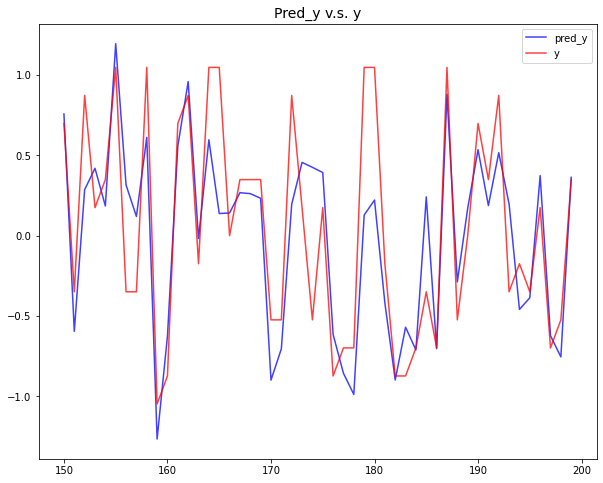

In [89]:
# Visualize data
fig2,ax2 = plt.subplots(1,1,figsize=(10,8))
ax2.plot([i for i in range(low_bound,high_bound)], list(pred_y), color='b', alpha=0.75, label='pred_y')
ax2.plot([i for i in range(low_bound,high_bound)], list(y_test.to_numpy()[low_bound:high_bound]), color='red', alpha=0.75, label='y')
ax2.set_title(f"Pred_y v.s. y",fontsize=14)
ax2.grid(False)
ax2.legend(loc='best')
plt.show()

### MLP ANN

In [24]:
le = LabelEncoder()

In [25]:
sc = StandardScaler()

In [26]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_test_std

array([[-1.53383171,  0.80051723,  1.74631085,  0.22648122,  1.58839804,
        -0.94058144],
       [ 0.75257566, -1.68416192, -1.28193799, -0.92587037, -1.4398277 ,
         0.92463649],
       [-1.57333376,  1.21937269,  0.83804217,  0.49933774,  1.69796219,
        -0.74876525],
       ...,
       [ 1.18587644,  0.16399331, -0.33000171, -0.71226287, -0.85238085,
         0.63764808],
       [ 0.77518153,  0.06709535,  0.02762136, -0.84189231, -0.36725268,
         0.07994146],
       [-0.43136146, -0.19824806,  0.263634  , -0.42694175,  0.54900767,
        -0.48417788]])

In [27]:
y_train_std = le.fit_transform(y_train)
y_test_std = le.fit_transform(y_test)
y_test_std

array([ 6, 11,  3,  6, 12, 10,  8,  6,  1,  1,  4, 11,  2, 11, 11,  4,  7,
        4, 10,  4,  6,  4, 11, 12,  3, 11,  9, 12,  0,  0,  2, 10,  1,  4,
        8,  7,  6,  1, 11,  1, 10,  8,  5, 11,  2,  3,  7, 10,  4, 10,  8,
       11,  4,  0,  4, 12,  0,  4, 10,  8, 12,  7, 10,  8,  8,  8, 10, 11,
        0, 11, 10, 11,  0,  8, 12,  5, 11,  3, 11,  6, 10,  8,  0,  6,  0,
        9, 11,  0,  7, 10,  7, 12,  0,  4, 11,  2,  4,  9,  6, 12,  7,  2,
       11,  7,  0,  7,  7,  6, 11, 10,  1,  2, 12,  0,  7,  4,  8,  0,  0,
        5,  9,  1,  6, 12, 12,  6, 10,  4,  8,  6,  7, 12,  5,  5,  9,  4,
       12,  6,  6,  8, 10,  4,  4,  9, 12,  8,  7, 10,  5,  3, 10,  4, 11,
        7,  8, 12,  4,  4, 12,  0,  1, 10, 11,  5, 12, 12,  6,  8,  8,  8,
        3,  3, 11,  7,  3,  7,  1,  2,  2, 12, 12,  5,  1,  1,  2,  4,  2,
       12,  3,  6, 10,  8, 11,  4,  5,  4,  7,  2,  3,  8,  2,  5, 11,  1,
        6,  4,  4,  3,  2, 12, 11,  6,  8,  4,  7, 11,  2,  2,  8,  5, 12,
        4,  4, 11,  4,  6

In [28]:
mlpr = MLPRegressor(hidden_layer_sizes=4, random_state=1, max_iter=500)
mlpr.fit(X_train_std, y_train_std)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=4, max_iter=500, random_state=1)

## Autoencoder + FC

In [29]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

In [53]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
print(X_train_np.shape)
print(y_train_np.shape)

(984, 6)
(984,)


In [54]:
maxX = np.max(X_train_np)
minX = np.min(X_train_np)
maxy = np.max(y_train_np)
miny = np.min(y_train_np)
X_train_np_std = (X_train_np.astype("float32") - minX)/(maxX-minX)
X_test_np_std = (X_test_np.astype("float32") - minX)/(maxX-minX)
y_train_np_std = (y_train_np.astype("float32") - miny)/(maxy-miny)

In [55]:
X_test_np_std.shape

(247, 6)

In [56]:
input_size = 6
hidden_size = 4
output_size = 6

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

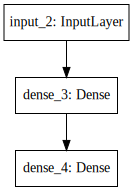

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [76]:
epochs = 500
batch_size = 200

history = autoencoder.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_np_std, X_test_np_std))

Train on 984 samples, validate on 247 samples
Epoch 1/500
984/984 [==============================] - 0s 11us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 2/500
984/984 [==============================] - 0s 9us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/500
984/984 [==============================] - 0s 8us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/500
984/984 [==============================] - 0s 24us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/500
984/984 [==============================] - 0s 12us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/500
984/984 [==============================] - 0s 11us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/500
984/984 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/500
984/984 [==============================] - 0s 29us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/500
984/984 [==============================] - 0s 36us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/500
984/984 [================

984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 81/500
984/984 [==============================] - 0s 12us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 82/500
984/984 [==============================] - 0s 25us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 83/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 84/500
984/984 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 85/500
984/984 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 86/500
984/984 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 87/500
984/984 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 88/500
984/984 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 89/500
984/984 [==============================] - 0s 20us/step - loss: 0.0022 - 

984/984 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 160/500
984/984 [==============================] - 0s 10us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 161/500
984/984 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 162/500
984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 163/500
984/984 [==============================] - ETA: 0s - loss: 0.002 - 0s 20us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 164/500
984/984 [==============================] - 0s 38us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 165/500
984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 166/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 167/500
984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 168/500
984/984 [==============================]

984/984 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 238/500
984/984 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 239/500
984/984 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 240/500
984/984 [==============================] - 0s 32us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 241/500
984/984 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 242/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 243/500
984/984 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 244/500
984/984 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 245/500
984/984 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 246/500
984/984 [==============================] - 0s 18us/step - loss: 

984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 316/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 317/500
984/984 [==============================] - 0s 26us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 318/500
984/984 [==============================] - 0s 13us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 319/500
984/984 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 320/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 321/500
984/984 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 322/500
984/984 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 323/500
984/984 [==============================] - 0s 20us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 324/500
984/984 [==============================] - 0s 12us/step - loss: 

Epoch 394/500
984/984 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 395/500
984/984 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 396/500
984/984 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 397/500
984/984 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 398/500
984/984 [==============================] - 0s 21us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 399/500
984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 400/500
984/984 [==============================] - 0s 24us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 401/500
984/984 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 402/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 403/500
984/984 [==============================] - 0s 33us

Epoch 473/500
984/984 [==============================] - 0s 16us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 474/500
984/984 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 475/500
984/984 [==============================] - 0s 41us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 476/500
984/984 [==============================] - 0s 18us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 477/500
984/984 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 478/500
984/984 [==============================] - 0s 17us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 479/500
984/984 [==============================] - 0s 23us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 480/500
984/984 [==============================] - 0s 14us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 481/500
984/984 [==============================] - 0s 22us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 482/500
984/984 [==============================] - 0s 16us

In [77]:
pred_X_test = autoencoder.predict(X_test)

In [90]:
pred_X_test.shape

(247, 6)

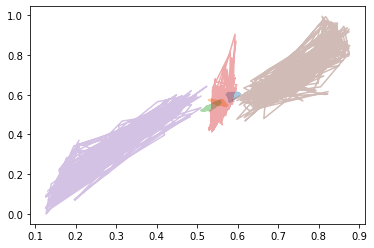

In [87]:
plt.plot(pred_X_test, X_test_np_std, alpha=.4)

dict_keys(['val_loss', 'loss'])


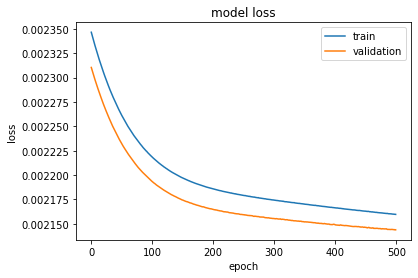

In [88]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## DNN!